<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Linear-Models/blob/master/C_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [33]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder

# I. Wrangle Data

**Task 1:** Use the `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [8]:
def convert_to_int(cell):
  cell = cell.replace(',', '')
  parts = cell.split(' ')
  return int(parts[-1])

def get_one_family(cell):
  words = cell.split(' ')
  category = words[0]
  if category == '01':
    return cell

def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    # The column 'SALE DATE' should become the DatetimeIndex.
    df = pd.read_csv(filepath, usecols=cols, parse_dates=['SALE DATE'], index_col='SALE DATE').sort_index()
    # The dtype for the 'BOROUGH' column should be object, not int.
    df['BOROUGH'] = df['BOROUGH'].apply(str)
    # The dtype for the 'SALE PRICE' column should be int, not object.
    df['SALE PRICE'] = df['SALE PRICE'].apply(convert_to_int)
    # The dataset should only include one-family dwellings (BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS').
    df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].apply(get_one_family)
    df = df.dropna()
    # The dataset should only include properties whose sale price is between \$100,000 and \$2,000,000.
    df = df[(df['SALE PRICE'] >= 100000) & (df['SALE PRICE'] <= 2000000)]
    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

df = wrangle(filepath)

In [9]:
df.shape

(3164, 6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3164 entries, 2019-01-01 to 2019-04-30
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BOROUGH                  3164 non-null   object 
 1   NEIGHBORHOOD             3164 non-null   object 
 2   BUILDING CLASS CATEGORY  3164 non-null   object 
 3   GROSS SQUARE FEET        3164 non-null   float64
 4   YEAR BUILT               3164 non-null   float64
 5   SALE PRICE               3164 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 173.0+ KB


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [11]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [12]:
target = 'SALE PRICE'
X = df.drop(columns=target)
y = df[target]

In [13]:
X.shape

(3164, 5)

In [14]:
y.shape

(3164,)

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [15]:
cutoff = '2019-03-31'
mask = X.index < cutoff 
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [19]:
X_train.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT
SALE DATE,,,,,
2019-03-29,5,NEW DORP-BEACH,01 ONE FAMILY DWELLINGS,921.0,1950.0
2019-03-29,5,NEW SPRINGVILLE,01 ONE FAMILY DWELLINGS,2128.0,1980.0
2019-03-29,5,PORT RICHMOND,01 ONE FAMILY DWELLINGS,1807.0,2018.0
2019-03-29,5,SOUTH BEACH,01 ONE FAMILY DWELLINGS,621.0,1930.0
2019-03-30,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1163.0,1950.0


In [22]:
X_test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT
SALE DATE,,,,,
2019-04-01,2,RIVERDALE,01 ONE FAMILY DWELLINGS,2272.0,1930.0
2019-04-01,2,THROGS NECK,01 ONE FAMILY DWELLINGS,720.0,1935.0
2019-04-01,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,2210.0,1925.0
2019-04-01,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1520.0,1915.0
2019-04-01,3,GERRITSEN BEACH,01 ONE FAMILY DWELLINGS,840.0,1925.0


# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [25]:
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Mean Price:', y_train.mean())
print('Baseline MAE:', baseline_mae)

Mean Price: 621011.2721493841
Baseline MAE: 216497.12357684076


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [28]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [29]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [30]:
model_r = Ridge(alpha=1.0)
model_r.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [31]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 131242.25387365912
Linear Test MAE: 7294092761315.756


**Task 10:** Check the training and test metrics for `model_r`.

In [32]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 127630.56507787386
Ridge Test MAE: 141206.1668531332


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [36]:
# Caculate R^2 score
training_r2 = mean_squared_error(y_train, model_r.predict(XT_train), squared=False)
test_r2 = mean_squared_error(y_test, model_r.predict(XT_test), squared=False)

print('Training RSME:', training_r2)
print('Testing RSME:', test_r2)
print()
print('Training R^2:', model_r.score(XT_train, y_train))
print('Testing R^2:', model_r.score(XT_test, y_test))

Training RSME: 182951.99769477072
Testing RSME: 217984.57781907285

Training R^2: 0.6154355712168953
Testing R^2: 0.4801135314484869


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

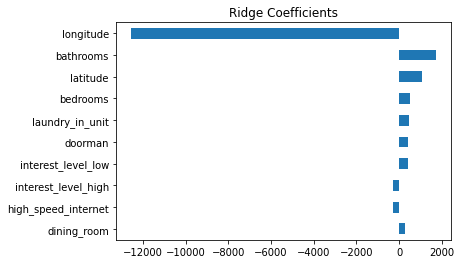

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

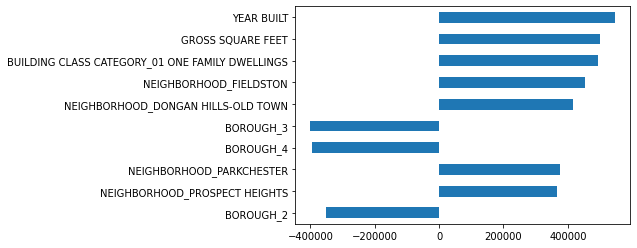

In [50]:
coeff = model_r.coef_
features = ohe.get_feature_names()
feat_importance = pd.Series(coeff, index=features).sort_values(key=abs)
feat_importance.tail(10).plot(kind='barh');

In [51]:
feat_importance.sort_values(key=abs)

NEIGHBORHOOD_ROSEBANK                                   0.000000
NEIGHBORHOOD_HIGHBRIDGE/MORRIS HEIGHTS                171.914427
NEIGHBORHOOD_OAKWOOD-BEACH                           -428.061733
NEIGHBORHOOD_PELHAM GARDENS                           462.980420
NEIGHBORHOOD_COLLEGE POINT                            769.811091
                                                       ...      
NEIGHBORHOOD_DONGAN HILLS-OLD TOWN                 416508.333046
NEIGHBORHOOD_FIELDSTON                             454108.383862
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS    493423.907909
GROSS SQUARE FEET                                  501031.672251
YEAR BUILT                                         545471.551527
Length: 186, dtype: float64